# Algorithmic Trading

Below is a comprehensive Python script that implements a complete algorithmic trading system. This project includes:

- **Data Collection & Preprocessing**: Downloads historical stock data via yfinance, cleans the data, and computes daily returns.
- **Strategy Implementation**: Uses a moving average crossover strategy (20-day SMA vs. 50-day SMA) to generate buy/sell signals.
- **Backtesting Framework**: Simulates trading based on the signals, calculates an equity curve, and includes basic risk management (a simple stop-loss mechanism and maximum drawdown calculation).
- **Performance Analysis & Visualization**: Computes performance metrics (total return, annualized return, volatility, Sharpe ratio, maximum drawdown) and generates various plots.

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


=== Performance Metrics ===
Final Market Value: $116,408.52
Final Strategy Value: $63,209.77
Final Adjusted Strategy Value: $102,134.48
Annualized Market Return: 8.86%, Volatility: 28.85%, Sharpe Ratio: 0.31
Annualized Strategy Return: -22.61%, Volatility: 28.83%, Sharpe Ratio: -0.78
Annualized Adjusted Strategy Return: 1.19%, Volatility: 5.38%, Sharpe Ratio: 0.22


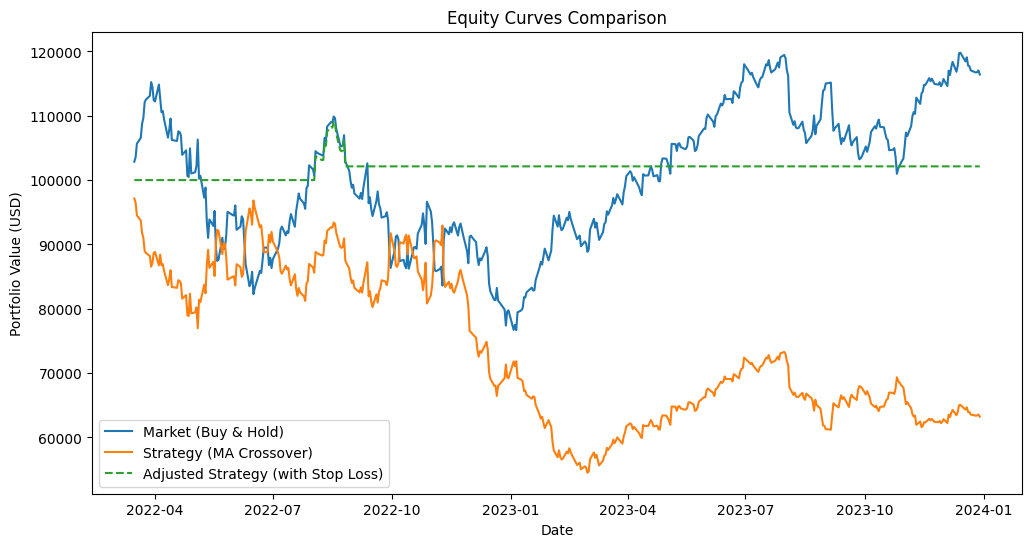

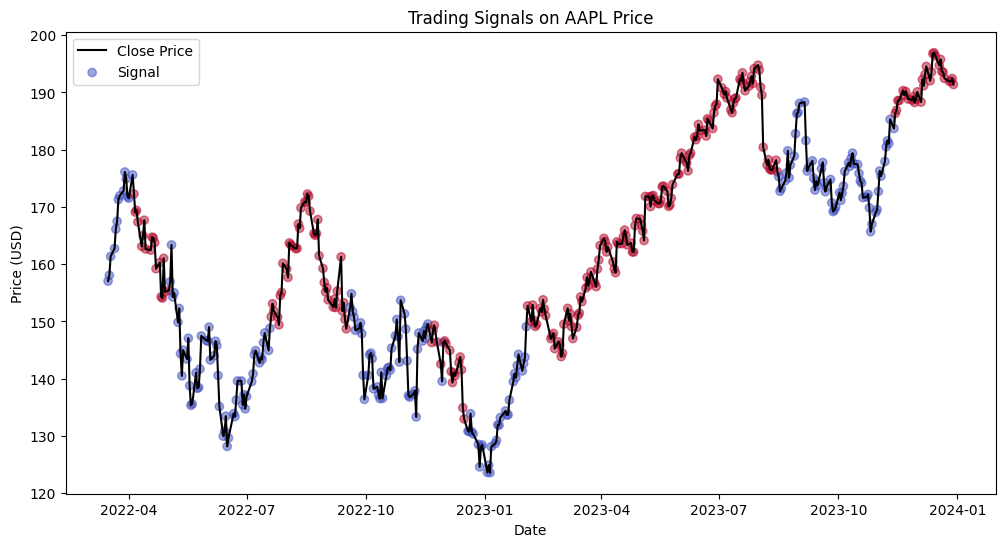

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import datetime

# ============================
# 1. Data Collection & Preprocessing
# ============================
ticker = 'AAPL'
start_date = '2022-01-01'
end_date = '2023-12-31'
initial_capital = 100000  # Starting portfolio value in USD

# Download historical data for the chosen ticker
data = yf.download(ticker, start=start_date, end=end_date)

# Forward fill missing values in 'Close'
data['Close'] = data['Close'].ffill()

# Calculate daily log returns
data['Daily Return'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)

# ============================
# 2. Strategy Implementation: Moving Average Crossover
# ============================
# Calculate moving averages
short_window = 20  # short-term period
long_window = 50   # long-term period

data['SMA_20'] = data['Close'].rolling(window=short_window).mean()
data['SMA_50'] = data['Close'].rolling(window=long_window).mean()

# Generate trading signals:
# Signal = 1 (Buy) when SMA_20 > SMA_50, -1 (Sell) otherwise
data['Signal'] = np.where(data['SMA_20'] > data['SMA_50'], 1, -1)

# To avoid look-ahead bias, shift the signals by 1 day
data['Strategy Signal'] = data['Signal'].shift(1)
data.dropna(inplace=True)

# ============================
# 3. Backtesting Framework & Basic Risk Management
# ============================
# Calculate strategy daily returns: when invested, return equals the stock's return
data['Strategy Return'] = data['Strategy Signal'] * data['Daily Return']

# Compute portfolio equity curve (cumulative returns)
data['Cumulative Market'] = (1 + data['Daily Return']).cumprod() * initial_capital
data['Cumulative Strategy'] = (1 + data['Strategy Return']).cumprod() * initial_capital

# Implement a simple risk management rule: Stop-loss
# For simplicity, if the cumulative strategy drawdown exceeds 10%, signal exit for next day.
max_drawdown_threshold = 0.10
data['Peak'] = data['Cumulative Strategy'].cummax()
data['Drawdown'] = (data['Cumulative Strategy'] - data['Peak']) / data['Peak']
data['Stop Loss Trigger'] = np.where(data['Drawdown'] < -max_drawdown_threshold, -1, data['Strategy Signal'])
# For the purpose of this backtest, if a stop loss is triggered, we assume we exit (i.e., zero exposure the next day)
data['Adjusted Signal'] = np.where(data['Stop Loss Trigger'] == -1, 0, data['Strategy Signal'])
data['Adjusted Strategy Return'] = data['Adjusted Signal'] * data['Daily Return']
data['Cumulative Adjusted Strategy'] = (1 + data['Adjusted Strategy Return']).cumprod() * initial_capital

# ============================
# 4. Performance Evaluation and Visualization
# ============================
# Performance Metrics Calculation
def annualized_return(cumulative_return, num_periods):
    return cumulative_return ** (252 / num_periods) - 1

def annualized_volatility(returns):
    return returns.std() * np.sqrt(252)

# Final portfolio performance
final_market = data['Cumulative Market'].iloc[-1]
final_strategy = data['Cumulative Strategy'].iloc[-1]
final_adjusted_strategy = data['Cumulative Adjusted Strategy'].iloc[-1]

# Annualized metrics based on the strategy period
num_days = len(data)
ann_return_market = annualized_return(data['Cumulative Market'].iloc[-1] / initial_capital, num_days)
ann_return_strategy = annualized_return(data['Cumulative Strategy'].iloc[-1] / initial_capital, num_days)
ann_return_adj_strategy = annualized_return(data['Cumulative Adjusted Strategy'].iloc[-1] / initial_capital, num_days)

ann_vol_market = annualized_volatility(data['Daily Return'])
ann_vol_strategy = annualized_volatility(data['Strategy Return'])
ann_vol_adj_strategy = annualized_volatility(data['Adjusted Strategy Return'])

# Assume risk-free rate = 0 for Sharpe Ratio calculation
sharpe_market = ann_return_market / ann_vol_market
sharpe_strategy = ann_return_strategy / ann_vol_strategy
sharpe_adj_strategy = ann_return_adj_strategy / ann_vol_adj_strategy

print("=== Performance Metrics ===")
print(f"Final Market Value: ${final_market:,.2f}")
print(f"Final Strategy Value: ${final_strategy:,.2f}")
print(f"Final Adjusted Strategy Value: ${final_adjusted_strategy:,.2f}")
print(f"Annualized Market Return: {ann_return_market:.2%}, Volatility: {ann_vol_market:.2%}, Sharpe Ratio: {sharpe_market:.2f}")
print(f"Annualized Strategy Return: {ann_return_strategy:.2%}, Volatility: {ann_vol_strategy:.2%}, Sharpe Ratio: {sharpe_strategy:.2f}")
print(f"Annualized Adjusted Strategy Return: {ann_return_adj_strategy:.2%}, Volatility: {ann_vol_adj_strategy:.2%}, Sharpe Ratio: {sharpe_adj_strategy:.2f}")

# Plot Equity Curves
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Cumulative Market'], label='Market (Buy & Hold)')
plt.plot(data.index, data['Cumulative Strategy'], label='Strategy (MA Crossover)')
plt.plot(data.index, data['Cumulative Adjusted Strategy'], label='Adjusted Strategy (with Stop Loss)', linestyle='--')
plt.title("Equity Curves Comparison")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (USD)")
plt.legend()
plt.show()

# Plot Trading Signals on Price Chart
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Close Price', color='black')
plt.scatter(data.index, data['Close'], c=data['Signal'], cmap='coolwarm', label='Signal', marker='o', alpha=0.5)
plt.title("Trading Signals on AAPL Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()
